### This module will investigate using LSTM for regression with the goal of achieving a ball-park estimate for the hyperparameters of the model

In [1]:
import meta
import pandas as pd
import numpy as np
import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
import keras

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from Daily_Preprocessor import Daily_Preprocessor

import matplotlib.pyplot as plt


In [14]:
x, y, x_n, price, buy, sell = Daily_Preprocessor('AAPL').produce_ind_and_response(stacked=True)

x_comp = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
x = StandardScaler().fit_transform(x_comp).reshape(x.shape)

In [2]:
x_r, y_r, x_names, _, __, ___ = Daily_Preprocessor('AAPL').produce_ind_and_response(n_weeks=200)


In [22]:
test_est = [int(n) for n in np.linspace(250, 750, 10)]
test_depth = [int(n) for n in np.linspace(300, 600, 10)]
num_trials = 10
mse_results = np.full((len(test_est), len(test_depth)), 0.0)
hl_results = np.full((len(test_est), len(test_depth)), 0.0)

for i, est in enumerate(test_est):
    for j, dep in enumerate(test_depth):
        for _ in range(num_trials):
            x_train, x_test, y_train, y_test = train_test_split(x_r, y_r)
            model = RandomForestRegressor(
                n_estimators=5, min_samples_split=2, min_samples_leaf=4, max_features='sqrt',
                max_depth=3, bootstrap=True
            )
            model.fit(x_train, y_train)
            ## Training
            pred = model.predict(x_train)
            hl_acc = ((pred > 1) & (y_train > 1)) | ((pred <=1) & (y_train <= 1))
            ## Testing
            pred = model.predict(x_test)
            hl_acc = ((pred > 1) & (y_test > 1)) | ((pred <=1) & (y_test <= 1))
            hl_results[i, j] = hl_acc.mean()
            mse_results[i, j] = ((pred - y_test) ** 2).mean()

In [16]:
## Applies a pooling of the given size over the heat map
def apply_avg_pool(hmap, pool_size, step):
    new_x_size = int(np.ceil((hmap.shape[0] - pool_size[0] + 1) / step[0]))
    new_y_size = int(np.ceil((hmap.shape[1] - pool_size[1] + 1) / step[1]))
    new_map = np.full((new_x_size, new_y_size), 0.0)
    for i in range(new_map.shape[0]):
        for j in range(new_map.shape[1]):
            new_map[i, j] = hmap[i*step[0]:i*step[0]+pool_size[0], j*step[1]:j*step[1]+pool_size[1]].mean()
    return new_map            

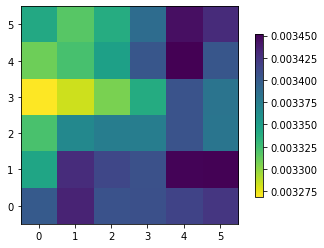

In [24]:
fig, ax = plt.subplots()
filtered = apply_avg_pool(mse_results, (5, 5), (1, 1))
cbar = ax.imshow(filtered, origin='lower', cmap='viridis_r')
fig.colorbar(cbar, ax=ax, shrink=0.75)

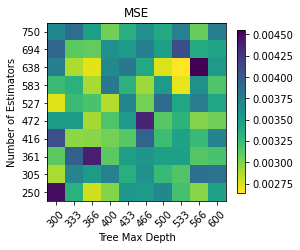

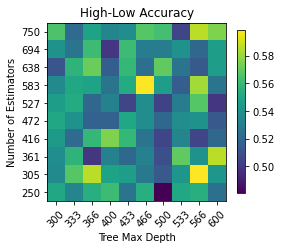

In [23]:
fig, ax = plt.subplots()
cbar = ax.imshow(mse_results, origin='lower', cmap='viridis_r')
ax.set_title('MSE')
ax.set_xlabel('Tree Max Depth')
ax.set_ylabel('Number of Estimators')
ax.set_xticks(np.arange(mse_results.shape[1]))
ax.set_xticklabels(test_depth, rotation=45)
ax.set_yticks(np.arange(mse_results.shape[0]))
ax.set_yticklabels(test_est)
fig.colorbar(cbar, ax=ax, shrink=0.75)
fig.set_size_inches(4, 4)

fig, ax = plt.subplots()
cbar = ax.imshow(hl_results, origin='lower')
ax.set_title('High-Low Accuracy')
ax.set_xlabel('Tree Max Depth')
ax.set_ylabel('Number of Estimators')
ax.set_xticks(np.arange(hl_results.shape[1]))
ax.set_xticklabels(test_depth, rotation=45)
ax.set_yticks(np.arange(hl_results.shape[0]))
ax.set_yticklabels(test_est)
fig.colorbar(cbar, ax=ax, shrink=0.75)
fig.set_size_inches(4, 4)

In [18]:
def build_model():
    model = Sequential()
    model.add(LSTM(100, input_shape = x.shape[1:], activation='relu', return_sequences=False))
    model.add(Dropout(0.005))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.005))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.005))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.005))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.005))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model



In [20]:
print(x.shape)
test = x.shape[0] // 5
test_start = x.shape[0] - test
ind = np.random.choice(np.arange(x.shape[0]), x.shape[0], replace=False)
x_tr = x[ind[:test_start]]
y_tr = y[ind[:test_start]]
x_te = x[ind[test_start:]]
y_te = y[ind[test_start:]]

#reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=10, verbose=1)
#model = KerasRegressor(build_fn=build_model, epochs=140, batch_size=x.shape[0]//5, validation_data=(x_te, y_te))
model = KerasRegressor(build_fn=build_model, 
            epochs=150, 
            batch_size=x_tr.shape[0], 
            validation_data=(x_te, y_te), 
            callbacks=[])
history = model.fit(x_tr, y_tr)

(2122, 40, 19)
Epoch 1/150
1/1 [==============================] - 1s 1s/step - loss: 0.8680 - val_loss: 0.7185
Epoch 2/150
1/1 [==============================] - 0s 336ms/step - loss: 0.7310 - val_loss: 0.5730
Epoch 3/150
1/1 [==============================] - 0s 331ms/step - loss: 0.5862 - val_loss: 0.4320
Epoch 4/150
1/1 [==============================] - 0s 333ms/step - loss: 0.4484 - val_loss: 0.2953
Epoch 5/150
1/1 [==============================] - 0s 331ms/step - loss: 0.2857 - val_loss: 69.7076
Epoch 6/150
1/1 [==============================] - 0s 341ms/step - loss: 3.8294 - val_loss: 0.6378
Epoch 7/150
1/1 [==============================] - 0s 331ms/step - loss: 0.1850 - val_loss: 0.2418
Epoch 8/150
1/1 [==============================] - 0s 329ms/step - loss: 0.1493 - val_loss: 0.1954
Epoch 9/150
1/1 [==============================] - 0s 332ms/step - loss: 0.1322 - val_loss: 0.1827
Epoch 10/150
1/1 [==============================] - 0s 332ms/step - loss: 0.1159 - val_loss: 0.1

In [21]:
pred = model.predict(x_te)

hl_acc = ((pred > 1) & (y_te > 1)) | ((pred <=1) & (y_te <= 1))
print('high-low', hl_acc.mean())
print('MSE', ((pred - y_te) ** 2).mean())

high-low 0.5188679245283019
MSE 0.008212998489385106


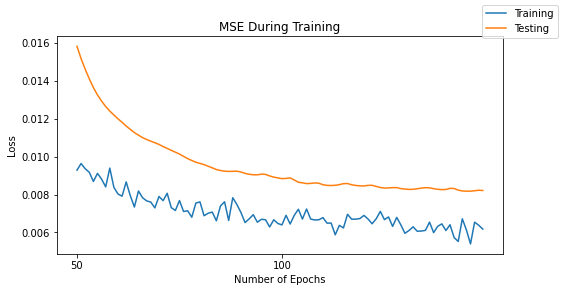

In [22]:
import matplotlib.pyplot as plt
loss = history.history['loss']
start_from = 50
val_loss = history.history['val_loss']
fig, ax = plt.subplots()
ax.plot(np.arange(len(loss) - start_from), loss[start_from:], label='Training')
ax.plot(np.arange(len(loss) - start_from),val_loss[start_from:], label='Testing')
ax.set_xticks(np.arange(len(loss) - start_from, step=50))
ax.set_xticklabels(np.arange(len(loss) - start_from, step=50) + start_from)
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss')
ax.set_title('MSE During Training')
fig.set_size_inches(8, 4)
fig.legend()

In [23]:
pred = model.predict(x_tr)

hl_acc = ((pred > 1) & (y_tr > 1)) | ((pred <=1) & (y_tr <= 1))
print('high-low', hl_acc.mean())
print('MSE', ((pred - y_tr) ** 2).mean())

high-low 0.5636042402826855
MSE 0.0036459656148743356


In [24]:
## Plots the feature importance for the model
def feature_importance(model, x_test, y_test, x_names, graph=True, stacked=False):
    orig_shape = x_test.shape
    new_shape = (x_test.shape[0], x_test.shape[1] * x_test.shape[2])
    real_pred = model.predict(x_test)
    real_mse = ((y_test - real_pred) ** 2).mean()
    importance = []
    if stacked:
        x_test = x_test.reshape(new_shape)
        
    for i in range(len(x_names)):
        x_prev = x_test[:, i].copy()
        x_test[:, i] = np.random.choice(x_test[:, i], x_test.shape[0], replace=True)
        if stacked:
            cur_pred = model.predict(x_test.reshape(orig_shape))
        else:
            cur_pred = model.predict(x_test)
        cur_mse = ((y_test - cur_pred) ** 2).mean()
        importance.append(np.abs(real_mse - cur_mse))
        x_test[:, i] = x_prev
    most_important = pd.Series(importance, index=x_names).sort_values(ascending=False)
    above_zero = most_important.loc[most_important > 0]
    
    if graph:
        fig, ax = plt.subplots()
        ax.bar(above_zero.index, above_zero.values)
        ax.set_title('Change in Error After Feature Shuffling')
        ax.set_xticks(np.arange(len(above_zero)))
        ax.set_xticklabels(above_zero.index, rotation=90)
        ax.set_xlabel('Feature')
        ax.set_ylabel('Distance From Baseline MSE')
        
    return above_zero.index

Index(['Close', 'High', 'May', 'Open', 'Jun', 'Volume', 'Low', 'Nov', 'Jul',
       'Oct', 'Apr', 'Jan', 'Aug', 'Mar', 'Feb', 'Dec', 'Sep', 'Stock Splits',
       'Dividends'],
      dtype='object')

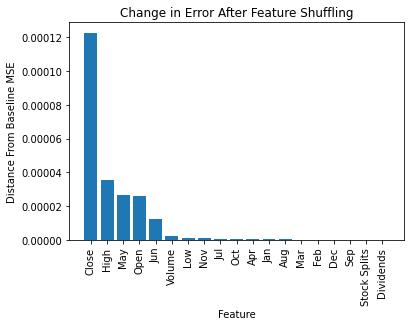

In [25]:
feature_importance(model, x_te, y_te, x_n, stacked=True)